## Exploration of RISE with binary MNIST

**Function        : Exploration of RISE with binary MNIST**<br>
**Author          : Team DIANNA**<br>
**Contributor     :**<br>
**First Built     : 2021.07.27**<br>
**Last Update     : 2021.08.12**<br>
**Library         : os, numpy, matplotlib, torch, rise**<br>
**Description     : In this notebook we test XAI method RISE (Randomized Input Sampling for Explanation of Black-box Models) using trained binary MNIST model.**<br>
**Return Values   : Saliency visualization**<br>
**Note**          : We use the original implementation of RISE to explain the model trained for MNIST.<br>
Link to the project page of the original paper: http://cs-people.bu.edu/vpetsiuk/rise/ <br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
# DL framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
# XAI framework
from explanations import RISE
from captum.attr import visualization as viz
# for plotting
import matplotlib.pyplot as plt

### Path to the dataset and the model

In [2]:
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist/binary-MNIST'
# please specify model path
model_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/example_data/model_generation/MNIST'

### Load data (binary MNIST)

In [3]:
# load binary MNIST from local
# load data
fd = np.load(os.path.join(datapath, 'binary-mnist.npz'))
# training set
train_X = fd['X_train']
train_y = fd['y_train']
# testing set
test_X = fd['X_test']
test_y = fd['y_test']
fd.close()

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits: 0 1")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))
print("Labels of training set", train_y[:20])

dimensions of mnist:
dimensions or training set (12665, 784)
dimensions or training set label (12665,)
dimensions or testing set (2115, 784)
dimensions or testing set label (2115,)
statistics of training set:
Digits: 0 1
labels: [0 1]
Class distribution: [5923 6742]
Labels of training set [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


### Prepare data as torch tensor

In [4]:
# use pytorch data loader
test_X_torch = torch.from_numpy(test_X).type(torch.FloatTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)
# reshape the input following the definition in pytorch (batch, channel, Height, Width)
test_X_torch = test_X_torch.view(-1,1,28,28)
height, width = test_X_torch[0,0,:,:].shape

### Load model (Pytorch model trained for binary MNIST)

In [5]:
# define the model first
class MnistNet(nn.Module):
    def __init__(self, kernels=[16, 32], dropout = 0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1]) # pixel 28 / maxpooling 2 * 2 = 7
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# hyper-parameters
kernels = [16, 32]
dropout = 0.5
classes = 2
# create model
model = MnistNet(kernels, dropout, classes)
# load whole model state
checkpoint = torch.load(os.path.join(model_path, 'mnistnet_training_checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Predict the class of the input image <br>

In [6]:
# check the prediction
model.eval()

# overall test accuracy
correct = 0
for i in range(len(test_X_torch)):
    output = model(test_X_torch[i:i+1,:,:,:])
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_y[i]).sum()

print("Test accuracy:{:.3f}% ".format(float(correct*100) / float(len(test_X_torch))))

# check one case
output = model(test_X_torch[:1,:,:,:])
predicted = torch.max(output,1)[1]
print("prediction", predicted)
print("ground truth", test_y[0])

Test accuracy:99.905% 
prediction tensor([1])
ground truth 1


### RISE-based attribution <br>
Compute attributions using RISE and visualize the saliency on the image. <br>
RISE estimates importance empirically by probing the model with randomly masked versions of the input image and obtaining the corresponding outputs.<br>

In other words, RISE masks random portions of the input image and passes this image through the model — the mask that damages accuracy the most is the most “important” portion.<br>

To generate a saliency map for model's prediction, RISE queries black-box model on multiple randomly masked versions of input. After all the queries are done we average all the masks with respect to their scores to produce the final saliency map. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score, and consequently has a higher weight in the sum.<br>

In [7]:
explainer = RISE(model, (height,width), 1)
explainer.generate_masks(N=6000, s=8, p1=0.1)

Generating filters: 100%|██████████| 6000/6000 [00:03<00:00, 1793.12it/s]


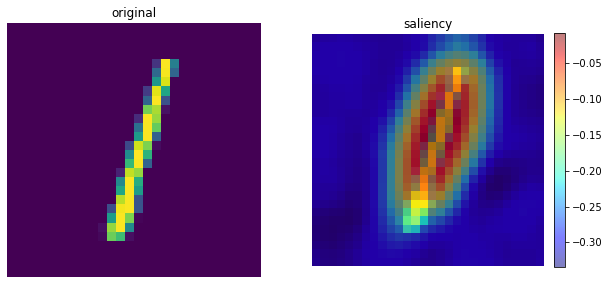

In [16]:
saliency = explainer(test_X_torch[0:1,:,:,:])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('original')
plt.imshow(test_X_torch[0,0,:,:])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('saliency')
plt.imshow(test_X_torch[0,0,:,:])
plt.imshow(saliency[test_y_torch[0],:,:], cmap='jet', alpha=0.5) # plot the 
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

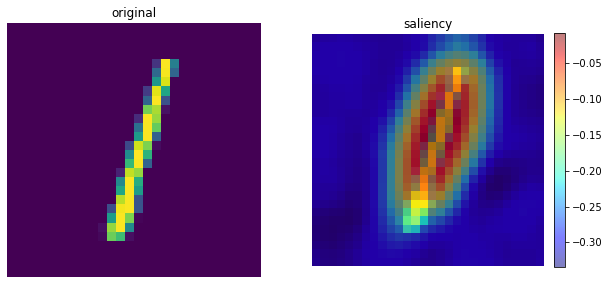

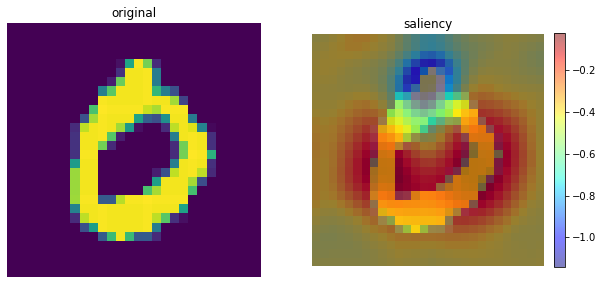

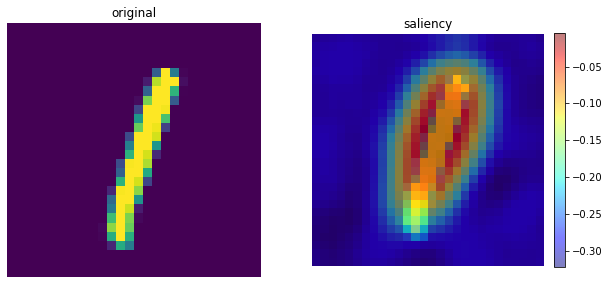

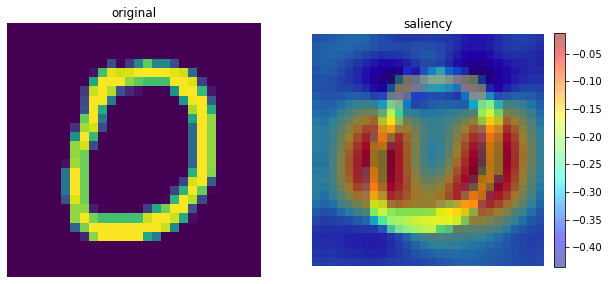

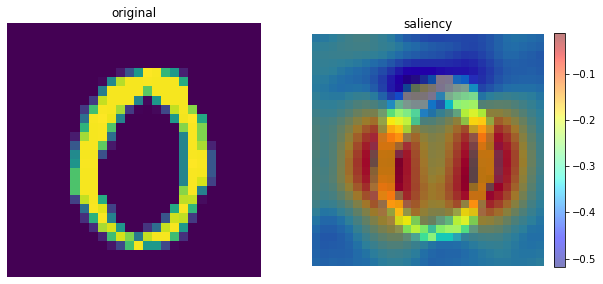

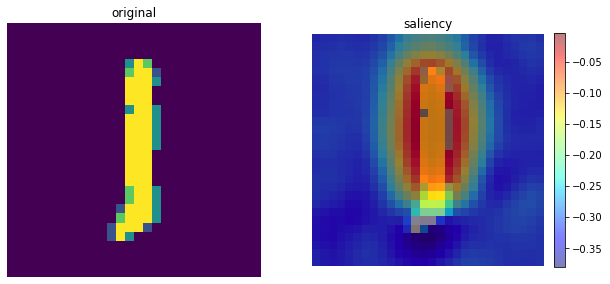

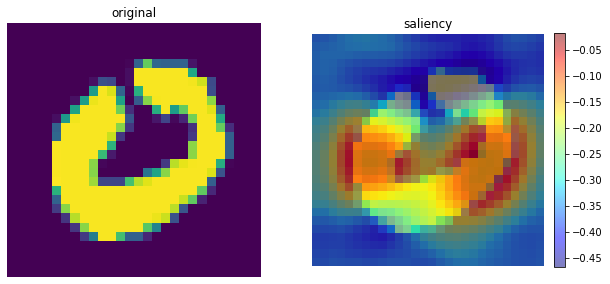

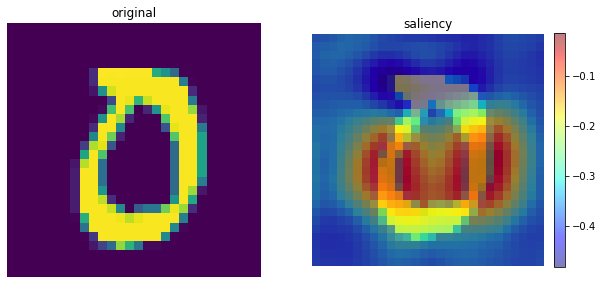

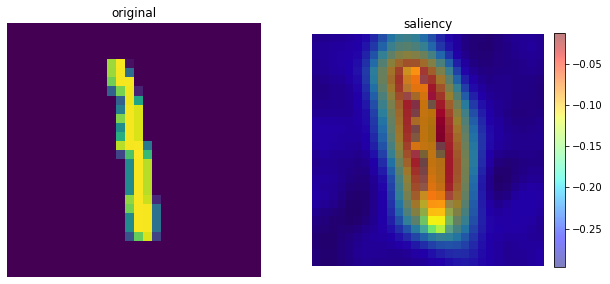

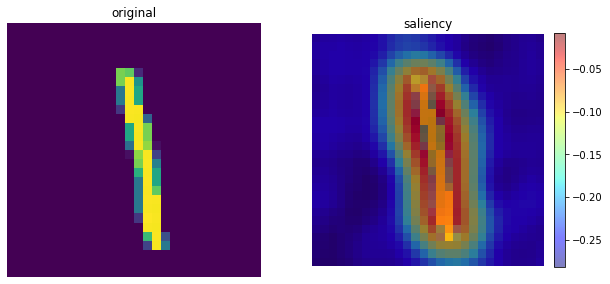

In [17]:
# plot the attribution for a number of cases
case = 10
for i in range(case):
    # call RISE method.
    saliency = explainer(test_X_torch[i:i+1,:,:,:]) # pass model and input
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(test_X_torch[i,0,:,:])

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('saliency')
    plt.imshow(test_X_torch[i,0,:,:])
    plt.imshow(saliency[test_y_torch[i],:,:], cmap='jet', alpha=0.5) # plot the 
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()